In [3]:
import os
os.chdir('../../')

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tqdm.notebook import tqdm
from pprint import pprint
from torch.utils.data import DataLoader

# Paths

In [3]:
dataset_root = '/datasets/20bn_something_something/v2/'
labels_root = os.path.join(dataset_root, 'labels')
videos_path = os.path.join(dataset_root, 'videos')

train_path = os.path.join(labels_root, 'something-something-v2-train.json')
valid_path = os.path.join(labels_root, 'something-something-v2-validation.json')
test_path = os.path.join(labels_root, 'something-something-v2-test.json')
labels_path = os.path.join(labels_root, 'something-something-v2-labels.json')

# Explore Videos

In [4]:
vids = os.listdir(videos_path)

In [4]:
def read_video_frames(path: str) -> (np.ndarray, float):
    
    vid = cv2.VideoCapture(path)
    fps = vid.get(cv2.CAP_PROP_FPS)
    
    frames = []
    while vid.isOpened():
        ret, frame = vid.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    return np.asarray(frames), fps

def get_video_fps(path: str) -> float:
    vid = cv2.VideoCapture(path)
    fps = vid.get(cv2.CAP_PROP_FPS)
    return fps

## Collect Statistics

Running this cell takes around 2~3 hours so it is favorable to run it overnight.

In [5]:
min_height = 1e9
max_height = 0
avg_height = 0

min_width = 1e9
max_width = 0
avg_width = 0

min_frame_num = 1e9
max_frame_num = 0
avg_frame_num = 0

min_duration_s = 1e9
max_duration_s = 0
avg_duration_s = 0

min_fps = 1e9
max_fps = 0
avg_fps = 0

num_vids = len(vids)

for v in tqdm(vids):
    
    frames, fps = read_video_frames(os.path.join(videos_path, v))
    
    F, H, W, _ = frames.shape
    
    min_height = min(min_height, H)
    max_height = max(max_height, H)
    avg_height += H
    
    min_width = min(min_width, W)
    max_width = max(max_width, W)
    avg_width += W
    
    min_frame_num = min(min_frame_num, F)
    max_frame_num = max(max_frame_num, F)
    avg_frame_num += F
    
    min_duration = min(min_duration, F / fps)
    max_duration = max(max_duration, F / fps)
    avg_duration += F / fps
    
    min_fps = min(min_fps, fps)
    max_fps = max(max_fps, fps)
    avg_fps += fps

avg_height /= num_vids
avg_width /= num_vids
avg_frame_num /= num_vids
avf_duration /= num_vids
avg_fps /= num_vids
    
print(f"Min Height: {min_height}")
print(f"Max Height: {max_height}")
print(f"Avg Height: {avg_height}")

print(f"Min Width: {min_width}")
print(f"Max Width: {max_width}")
print(f"Avg Width: {avg_width}")

print(f"Min Frame Num: {min_frame_num}")
print(f"Max Frame Num: {max_frame_num}")
print(f"Avg Frame Num: {avg_frame_num}")

print(f"Min Duration (s): {min_frame_num}")
print(f"Max Duration (s): {max_frame_num}")
print(f"Avg Duration (s): {avg_frame_num}")


print(f"Min FPS: {min_fps}")
print(f"Max FPS: {max_fps}")
print(f"Avg FPS: {avg_fps}")

NameError: name 'vids' is not defined

# Explore Labels

In [61]:
os.listdir(labels_path)

['something-something-v2-labels.json',
 'something-something-v2-test.json',
 'something-something-v2-train.json',
 'something-something-v2-validation.json']

In [69]:
with open(labels_path, 'rb') as f:
    labels = json.load(f)

In [73]:
pprint(labels)

{'Approaching something with your camera': '0',
 'Attaching something to something': '1',
 'Bending something so that it deforms': '2',
 'Bending something until it breaks': '3',
 'Burying something in something': '4',
 'Closing something': '5',
 'Covering something with something': '6',
 'Digging something out of something': '7',
 'Dropping something behind something': '8',
 'Dropping something in front of something': '9',
 'Dropping something into something': '10',
 'Dropping something next to something': '11',
 'Dropping something onto something': '12',
 'Failing to put something into something because something does not fit': '13',
 'Folding something': '14',
 'Hitting something with something': '15',
 'Holding something': '16',
 'Holding something behind something': '17',
 'Holding something in front of something': '18',
 'Holding something next to something': '19',
 'Holding something over something': '20',
 'Laying something on the table on its side, not upright': '21',
 'Lettin

In [207]:
with open(test_path, 'rb') as f:
    valid_data = json.load(f)

In [208]:
len(valid_data)

27157

In [209]:
valid_data[100]

{'id': '20019'}

In [1]:
import os
import cv2
import json
import numpy as np
import random
import math
import torch
from torch.utils.data import Dataset
from typing import Any

class SSV2Dataset(Dataset):
    """
    Pytorch Dataset for Something-Something-V2 Dataset
    """
    
    dataset_root = '/datasets/20bn_something_something/v2/'
    labels_root = os.path.join(dataset_root, 'labels')
    videos_path = os.path.join(dataset_root, 'videos')
    train_path = os.path.join(labels_root, 'something-something-v2-train.json')
    valid_path = os.path.join(labels_root, 'something-something-v2-validation.json')
    test_path = os.path.join(labels_root, 'something-something-v2-test.json')
    labels_path = os.path.join(labels_root, 'something-something-v2-labels.json')
    
    def __init__(self, mode: str, num_samples: int, transforms=None, filter_by_labels=None):
        super().__init__()
        
        self.mode = mode
        self.num_samples = num_samples
        self.transforms = transforms
        self.labels_dict = self._read_labels_dict()
        self.labels = self._read_labels(mode)
        
        if filter_by_labels is not None:
            self.labels = filter_by_labels(self.labels)
        
        self.data_len = len(self.labels)
    
    def _read_labels(self, mode: str):
        
        path = None
        
        if mode == 'train':
            path = self.train_path
        elif mode == 'valid':
            path = self.valid_path
        elif mode == 'test':
            path = self.test_path
        else:
            raise ValueError(f"Undefined SSV2 Dataset Mode: {mode}")
        
        with open(path, 'rb') as f:
            data = json.load(f)
            
        if mode == 'test':
            return data
            
        for i in range(len(data)):
            idx = data[i]['id']
            label = self._clean_label(data[i]['template'])
            data[i] = {
                'id': data[i]['id'],
                'label_str': label,
                'label': int(self.labels_dict[label])
            }

        return data
    
    def _clean_label(self, label: str):
        
        label = label.replace("[", "")
        label = label.replace("]", "")
        
        return label
    
    def _read_labels_dict(self):
        
        with open(self.labels_path, 'rb') as f:
            labels = json.load(f)
        
        return labels
    
    def _read_video_frames(self, path: str) -> (np.ndarray, float):
    
        vid = cv2.VideoCapture(path)
        fps = vid.get(cv2.CAP_PROP_FPS)

        frames = []
        while vid.isOpened():
            ret, frame = vid.read()

            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        return np.asarray(frames), fps
    
    def _sample_random(self, frames: np.ndarray) -> np.ndarray:
        
        num_frames = frames.shape[0]
        num_samples = self.num_samples
        # if number of required frames is more than available frames
        # then set number of required frames to available frames
        if num_frames < num_samples:
            
            frame = frames[-1][None,:,:,:]
            diff = num_samples - num_frames
            frames = np.concatenate([frames, np.concatenate([frame for _ in range(diff)])])
            num_frames = num_samples
       
        seg_len = math.ceil(num_frames / num_samples)
        
        segments = np.array_split(range(num_frames), num_samples)
        selected_frames = []
        for seg in segments:
            selected_frames.append(np.random.choice(seg))
    
        return frames[selected_frames]
            
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index: int):
        
        if self.mode != 'test':
            label = self.labels[index]['label']
        
        vid_id = self.labels[index]['id']
        vid_path = os.path.join(self.videos_path, str(vid_id) + '.webm')
        frames, fps = self._read_video_frames(vid_path)
        
        frames = self._sample_random(frames)
        
        if self.transforms:
            frames_transformed = [0] * frames.shape[0]
            for i in range(frames.shape[0]):
                frames_transformed[i] = self.transforms(frames[i]).unsqueeze(0)
            frames = torch.cat(frames_transformed, axis=0)
        
        if self.mode == 'test':
            return frames
        
        return frames, label

In [78]:
dataset = SSV2Dataset(mode='train', num_samples=10)

In [79]:
len(dataset)

168913

In [5]:
from torchvision import transforms
label_count = {}
frame_count = 0

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

dataset = SSV2Dataset(mode='train', num_samples=10, transforms=transform)

mean = np.array([0, 0, 0], dtype=np.float64)
std = np.array([0, 0, 0], dtype=np.float64)

loader = DataLoader(dataset, batch_size=64, num_workers=18)

for (vid, labels) in tqdm(loader):
    for label in labels:
        if label in label_count:
            label_count[label] += 1
        else:
            label_count[label] = 0
    
    frame_count += vid.shape[0] * vid.shape[1]
    
    x = vid.permute(0, 2, 1, 3, 4).reshape(vid.shape[0], 3, -1)
    mean += x.mean(axis=2).sum(0).numpy()
    std += x.std(axis=2).sum(0).numpy()

mean /= frame_count
std /= frame_count

mean, std

(array([0.04675706, 0.04264063, 0.04014115]),
 array([0.02139871, 0.02166828, 0.02179769]))

In [11]:
list(label_count.keys())

[tensor(19),
 tensor(141),
 tensor(109),
 tensor(31),
 tensor(16),
 tensor(94),
 tensor(138),
 tensor(100),
 tensor(34),
 tensor(14),
 tensor(146),
 tensor(84),
 tensor(81),
 tensor(45),
 tensor(169),
 tensor(19),
 tensor(170),
 tensor(148),
 tensor(9),
 tensor(154),
 tensor(30),
 tensor(44),
 tensor(45),
 tensor(129),
 tensor(8),
 tensor(152),
 tensor(20),
 tensor(37),
 tensor(94),
 tensor(97),
 tensor(6),
 tensor(106),
 tensor(130),
 tensor(151),
 tensor(87),
 tensor(158),
 tensor(34),
 tensor(6),
 tensor(87),
 tensor(54),
 tensor(22),
 tensor(125),
 tensor(12),
 tensor(153),
 tensor(152),
 tensor(143),
 tensor(95),
 tensor(153),
 tensor(37),
 tensor(100),
 tensor(6),
 tensor(151),
 tensor(119),
 tensor(13),
 tensor(113),
 tensor(43),
 tensor(106),
 tensor(15),
 tensor(110),
 tensor(35),
 tensor(103),
 tensor(30),
 tensor(160),
 tensor(84),
 tensor(65),
 tensor(105),
 tensor(135),
 tensor(19),
 tensor(18),
 tensor(45),
 tensor(118),
 tensor(94),
 tensor(20),
 tensor(170),
 tensor(31)

In [13]:
k = dataset[0]

In [14]:
def filter_by_highest_class(upper_limit):

    def filter_num(data, upper_limit=upper_limit):
        result = []
        for d in data:
            if d['label'] < upper_limit:
                    result.append(d)
    
        return result
    
    return filter_num

In [15]:
dataset_filtered = SSV2Dataset(mode='train', num_samples=10, filter_by_labels=filter_by_highest_class(20))

In [16]:
len(dataset_filtered)

60541

In [ ]:
for i in tqdm(range(len(dataset_filtered))):
    vid = dataset_filtered[i]
    for j in range(dataset_filtered[i][0].shape[0])

# Explore Transforms

In [37]:
sample, label = dataset_filtered[20]

In [38]:
sample.shape, type(sample)

((10, 240, 427, 3), numpy.ndarray)

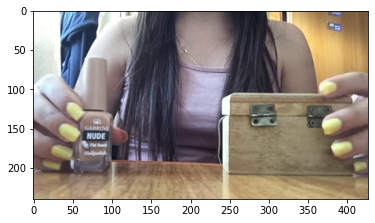

In [40]:
img = sample[2]

plt.imshow(img)

In [43]:
t = transforms.ToTensor()(img)

t.shape, type(t)

(torch.Size([3, 240, 427]), torch.Tensor)

In [73]:
k = transforms.RandomPerspective(0.5, 0.9)(t)

(<matplotlib.image.AxesImage at 0x2b6ee0180d60>,
 torch.Size([3, 240, 427]),
 torch.Tensor)

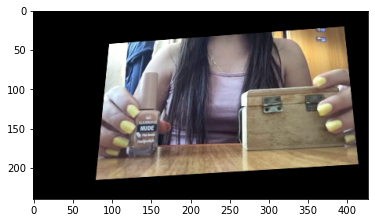

In [76]:
plt.imshow(k.permute(1, 2, 0)), k.shape, type(k)

In [15]:
a = torch.randn(5, 4, 7, 6)
b = torch.randn(5, 1, 7, 6)
c = torch.cat([a, b], axis=1)

c.shape

torch.Size([5, 5, 7, 6])